# Tutorial for `dukes`

In this tutorial, I'll briefly go through main classes and functions that are used to evaluate the signatures of diffuse boosted dark matter yielded by the supernova neutrinos in the high-redshit galaxies from the early Universe.


We begin with importing `dukes` and other useful packages in this tutorial. Note that `multiprocessing` is not compatible with jupyter on Mac/Windows systems.
One can alternatively use `ipyparallel` to manifest multiprocessing feature on jupyter. This task is relegated to the user.

In [34]:
#import multiprocessing as mp
#import numpy as np
#from scipy.integrate import quad
#import matplotlib.pyplot as plt
from functools import partial
#import dukes

## Useful constants

We introduce the fundamental class `constant` that is frequently inhereited by other classes in `dukes`. This class contains various physical constants and conversion factors that are commonly used in this package.
For example the physical quantities such as electron mass $m_e$, proton mass $m_p$, neutron mass $m_n$ and the Solar mass $M_\odot$ are expressed in MeV

In [12]:
dukes.constant.me, dukes.constant.mp, dukes.constant.mn, dukes.constant.Msun

(0.511, 938.2, 939.5, 1.115e+60)

Conversion factors like erg to MeV, year to seconds and kiloparsec to centimeters

In [13]:
dukes.constant.erg2MeV, dukes.constant.year2Seconds, dukes.constant.kpc2cm

(624100.0, 31560000.0, 3.085e+21)

Other constants can be checked form the docstring of the class.

## Baryonic density distribution of galaxy

We implement the baryonic density profile $\rho_b(R,z)$ shown in McMillan, *MNRAS* **465**, 76 (2017) for Milky Way (MW) at given $(R,z)$ in cylindrical coordinate, where $R$ is the radius to the galactic center and $z$ the height. It is obtained from `dukes.mwDensityProfile(R,z)` as `(R,z)` are in kpc and the output is $M_\odot\,{\rm kpc^{-3}}$.

In [5]:
dukes.mwDensityProfile(1,0.1)

1272762188.4977636

Since the height $z$ is much smaller than the radius $R$, we can further evaluate the area density by integrating out $z$ for later convenience
$$
\Sigma_b(R)= 2\int_{0}^{z_{\rm max}} dz ~\rho_b(R,z).
$$
The factor 2 is a natural consequence of symmetric $\rho_b$ under $z\to-z$, and $z_{\rm max}$ is the truncation point. In principle $\rho_b(R,z)$ varies little when $z$ is larger than a few kpc. We can safely set $z_{\rm max}=10$ kpc.

In [23]:
def Sigma_b(R,zmax=10):
    return quad(lambda z: dukes.mwDensityProfile(R,z),-zmax,zmax)[0]
# initializing mp
pool = mp.Pool(8)
RList = np.logspace(-3,2,30)
Sigma_b_data = pool.map(Sigma_b,RList)

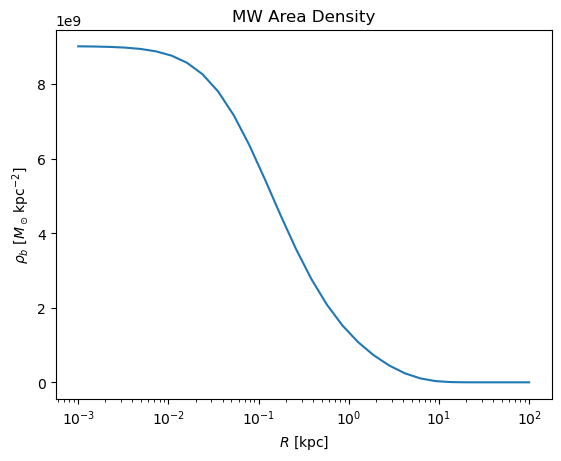

In [25]:
plt.plot(RList,Sigma_b_data)
plt.xscale('log')
plt.title('MW Area Density')
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$\rho_b~[M_\odot\,{\rm kpc^{-2}}]$')
plt.show()

For galaxies with arbitrary stellar mass $M_G$, we assume the baryonic profile still follows MW but the corresponding characteristic quantities are scaled with $M_G$. For characteristic radius, we assume it is proportional to $M_G^{1/3}$ and for density is proportional to $M_G$. All these quantities will degenerate to MW's when $M_G=M_{\rm MW}$ where $M_{\rm MW}$ is the MW stellar mass.

The corresponding function is `dukes.galacticDensityProfile(R,z,MG)` where `(R,z,MG)` are in (kpc, kpc, $M_\odot$) and the output is $M_\odot\,{\rm kpc}^{-3}$.

In [26]:
dukes.galacticDensityProfile(5.9,0.1,1e10)

8471024.103398217

We can compare with `dukes.mwDensityProfile` and found that the scaled density is smaller than the exact case and the error increase with $(R,z)$. This might seen troubling but it is not actually, as the contribution at large $(R,z)$ is small. They won't really matter when we estimate the SN position for galaxy with arbitrary $M_G$ in the later study.

In [39]:
def error_compare(R,z):
    exact = dukes.mwDensityProfile(R,z)
    scaled = dukes.galacticDensityProfile(R,z,dukes.constant.Mmw) 
    return 100*(scaled-exact)/exact

# initializing mp
pool2 = mp.Pool(8)
z0 = pool2.map(partial(error_compare,z=0),RList)
z01 = pool2.map(partial(error_compare,z=0.1),RList)
z05 = pool2.map(partial(error_compare,z=0.5),RList)
z5 = pool2.map(partial(error_compare,z=5),RList)

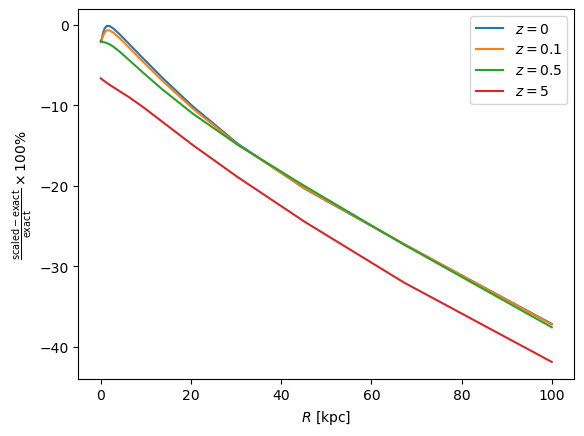

In [48]:
plt.plot(RList,z0,label=r'$z=0$')
plt.plot(RList,z01,label=r'$z=0.1$')
plt.plot(RList,z05,label=r'$z=0.5$')
plt.plot(RList,z5,label=r'$z=5$')
#plt.xscale('log')
plt.legend()
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$\frac{\rm scaled - exact}{\rm exact}\times 100\%$')
plt.show()

The area density for arbitrary $M_G$ can be evaluated by `dukes.galacticAreaDensity(R,zRange=[-10,10],MG=None)` where `R` is in kpc, `zRange` the integration for height $z$ and `MG` the galactic mass. The output is $M_\odot\,{\rm kpc}^{-2}$. If `MG` is `None` then it automatically calls `dukes.mwDensityProfile`, and `dukes.galacticDensityProfile` otherwise.

In [58]:
R,zRange,MG = 5,[-2,18],5.7e9
dukes.galacticAreaDensity(R,zRange,MG)

3164531.512063145

## Dark matter halo profile

##　Supernova neutrino spectrum

## DBDM flux and event evaluations

## Implementation of model-dependent differential cross section :: *experimental*

In [ ]:
from dukes.utils import userPhenoModelInterface

In [2]:
file = np.load('src/bin/densityParamFit.npz')

In [12]:
file2 = np.load('src/bin/galcticAreaDensityFit.npz')

In [21]:
np.savetxt('galcticAreaDensityFit.txt',file2['R'],fmt='%.3f',delimiter=",")

In [41]:
with open("galcticAreaDensityFit.txt", "w") as f:
    f.write('_R_data = [')
    for s in file2['R'].tolist():
        f.write('{:.5e}'.format(s) +", ")
    f.write('] \n\n')
    
    f.write('_MG_area_data = [')
    for s in file2['MG'].tolist():
        f.write('{:.5e}'.format(s) +", ")
    f.write('] \n\n')
    
    f.write('_rho_data = [')
    for line in file2['AreaDensity']:
        f.write('[')
        i = 0
        for s in line.tolist():
            if i != 120:
                f.write('{:.5e}'.format(s) +", ")
            else:
                f.write('{:.5e}'.format(s))
            i+=1
        f.write('],\n')
    f.write('] \n\n')

In [40]:
len(file2['AreaDensity'][0])

121

In [4]:
doom.dbdmFlux(5,1,neval=20000)

4.200418880077646e-08

In [5]:
doom.dbdmFlux(5,1,neval=50000)

4.422705310516041e-08

In [7]:
file['Sigma0Thin']

array([ 8.95223   ,  8.95223595,  8.95223594,  8.95223606,  8.95223595,
        8.95223595,  8.95223589,  8.95223593,  8.95223593,  8.95223595,
        8.95223594,  8.95223595,  8.95223596,  8.95225806,  8.95392236,
        8.9737703 ,  9.06911746,  9.31833401,  9.73665309, 10.28418383,
       10.9154326 , 11.59714772])

In [10]:
densityParamData = {
    'MG':[4.5,5.0,5.5,6.0,6.5,
          7.0,7.5,8.0,8.5,9.0,
          9.5,10.0,10.5,11.0,11.5,
          12.0,12.5,13.,13.5,14.0,
          14.5,15.0],
    'rho_b0':[8.822,8.922,9.046,9.190,9.358,
              9.548,9.758,9.985,10.228,10.4848,
              10.749,11.023,11.3035,11.588,11.877,
              12.170,12.469,12.785,13.128,13.496,
              13.890,14.317],
    'Sigma0Thick':[8.262,8.262,8.262,8.262,8.262,
                   8.262,8.262,8.262,8.262,8.262,
                   8.262,8.263,8.280,8.340,8.465,
                   8.694,9.070,9.582,10.189,10.856,
                   11.559,12.282],
    'Sigma0Thin':[8.952,8.952,8.952,8.952,8.952,
                  8.952,8.952,8.952,8.952,8.952,
                  8.952,8.952,8.952,8.952,8.953,
                  8.973,9.069,9.318,9.736,10.284,
                  10.915,11.597],
}

In [11]:
densityParamData['MG']

[4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0]

In [42]:
import dbdm

In [45]:
dbdm.galacticAreaDensity(0.9,MG=1e11)

1934198492.13079

In [51]:
dbdm.galacticAreaDensity(180,MG=1e8)/dbdm.galacticAreaDensityFit((180,8))

0.9944093709074541